In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

from utils import update_paid_days, update_paid_days_historical, google_plot
from python_ml_common.loader import RedshiftLoader

Instantiate env vars if not already set in jupyter startup commands, which can be done by adding following to settings.json:

```
"jupyter.runStartupCommands": [
    "%load_ext autoreload",
    "%autoreload 2",
    "from python_ml_common.config import load_envvars",
    "load_envvars()",
    "import os",
    "os.environ['PATH'] += ':/opt/homebrew/bin'", //Fix weirdness on local
  ]
```

In [3]:
from python_ml_common.config import load_envvars
load_envvars()

In [5]:
rs = RedshiftLoader()

### (0) Data

In [7]:
with open('google_actual_ltv_12_60.sql', 'r') as f:
    sql = f.read()
    signup_value = rs.load(sql)

In [2]:
# Read data
signup_value_1 = pd.read_csv('estimated_signup_value_channel_3.csv')
signup_value_2 = pd.read_csv('estimated_signup_value_channel_3_Brand.csv')
signup_value = pd.concat([signup_value_1, signup_value_2]).reset_index(drop=True)

signup_value.signup_month = pd.to_datetime(signup_value.signup_month)
signup_value['projected_paid_days'] = signup_value['projected_paid_days'].astype('float64')
signup_value = signup_value.loc[signup_value.signup_month <'2024-09-01'].reset_index(drop=True)

In [3]:
## DATA NOT COMPLETE YET -> NEED TO GO THROUGH THIS STEP TO COMPLETE FILLING PROJECTED_PAID_DAYS
# Fill in projected_paid_days
for channel in ['Google_Desktop', 'Google_Mobile', 'Google_Desktop_Brand', 'Google_Mobile_Brand']:
    signup_month_start = pd.to_datetime('2022-01-01')
    update_paid_days(signup_month_start, channel, signup_value)

    signup_month_start = pd.to_datetime('2022-01-01')
    update_paid_days_historical(signup_month_start, channel, signup_value)

### (1) Actual PCP

In [4]:
# Actual PCP
summary_actual = signup_value.groupby(['channels', 'signup_month'], as_index=False).agg({'pcp_modified_with_halo' : 'sum'})
summary_actual.rename({'pcp_modified_with_halo' : 'realized_pcp'}, axis=1, inplace=True)

### (2) 12-mo/60-mo actual+projected PCP

In [5]:
# Additional columns to compute 12-mo actual+projected PCP
signup_value = signup_value.loc[signup_value.increments_from_signup <= 12].reset_index(drop=True)
signup_value['projected_paid_days_per_signup'] = signup_value['projected_paid_days']/signup_value['signups']
signup_value['projected_net_revenue_per_signup'] = signup_value['projected_paid_days_per_signup']*signup_value['projected_net_revenue_per_day']
signup_value['projected_cost_per_signup'] = signup_value['projected_paid_days_per_signup']*signup_value['projected_cost_per_day']
signup_value['projected_pcp_per_signup'] = signup_value['projected_paid_days_per_signup']*(signup_value['projected_net_revenue_per_day']*0.98 - signup_value['projected_cost_per_day'])
signup_value['projected_pcp_per_signup_with_halo'] = signup_value['projected_pcp_per_signup']*signup_value['avg_paid_halo']
signup_value['projected_net_revenue'] = signup_value['projected_net_revenue_per_signup']*signup_value['signups']
signup_value['projected_pcp_with_halo'] = signup_value['projected_pcp_per_signup_with_halo']*signup_value['signups']
signup_value['final_pcp_with_halo'] = signup_value['projected_pcp_with_halo']
signup_value['accumulated_final_pcp_with_halo'] = signup_value.groupby(['channels', 'signup_month'], as_index=False)['final_pcp_with_halo'].cumsum()

signup_value['projected_days_weight'] = signup_value.groupby(['channels', 'signup_month'], as_index=False)[['projected_paid_days']].transform(lambda x : x/x.sum())
signup_value['projected_net_revenue_per_day_weighted'] = signup_value['projected_net_revenue_per_day']*signup_value['projected_days_weight']
signup_value['projected_cost_per_day_weighted'] = signup_value['projected_cost_per_day']*signup_value['projected_days_weight']
#signup_value.loc[(signup_value.channels== 'Google_Mobile_Brand') & (signup_value.signup_month =='2024-05-01'), ['channels', 'signup_month', 'increments_from_signup', 'pcp_modified_with_halo', 'projected_pcp_with_halo', 'final_pcp_with_halo', 'projected_cost_per_day']]

In [6]:
## 12-mo and 60-mo actual+projected PCP
summary_estimated = signup_value.groupby(['channels', 'signup_month'], as_index=False).agg({'signups' : 'first', 'final_pcp_with_halo' : 'sum'})
summary_estimated.rename({'final_pcp_with_halo' : '12_mo_pcp'}, axis=1, inplace=True)
summary_estimated['12_mo_pcp_per_signup'] = summary_estimated['12_mo_pcp']/summary_estimated['signups']
summary_estimated['60_mo_pcp_per_signup'] = summary_estimated['12_mo_pcp_per_signup']*2

### (3) Channel-level graphs : actual, 12-month, 60-month PCP + Cost

In [7]:
# CPS data
cps = pd.read_csv('cost_per_signup.csv')
cps['date'] = pd.to_datetime(cps['date'])
cps_google = cps.loc[cps.channel.isin(['Google_Desktop', 'Google_Mobile', 'Google_Desktop_Brand', 'Google_Mobile_Brand'])].reset_index(drop=True)
cps_google.rename({'signups' : 'signups_cps'}, axis=1, inplace=True)

In [8]:
# All : Actual, 12-mo actual+projected, 60-mo actual+projected
summary_all = pd.merge(summary_estimated, summary_actual, on=['channels', 'signup_month'], how='left')
summary_all = pd.merge(summary_all, cps_google[['channel', 'date', 'spend_actuals', 'signups_cps']], left_on = ['channels', 'signup_month'], right_on = ['channel', 'date'], how = 'left')
summary_all['realized_pcp_per_signup'] = summary_all['realized_pcp']/summary_all['signups']
summary_all['cps'] = summary_all['spend_actuals']/summary_all['signups_cps']

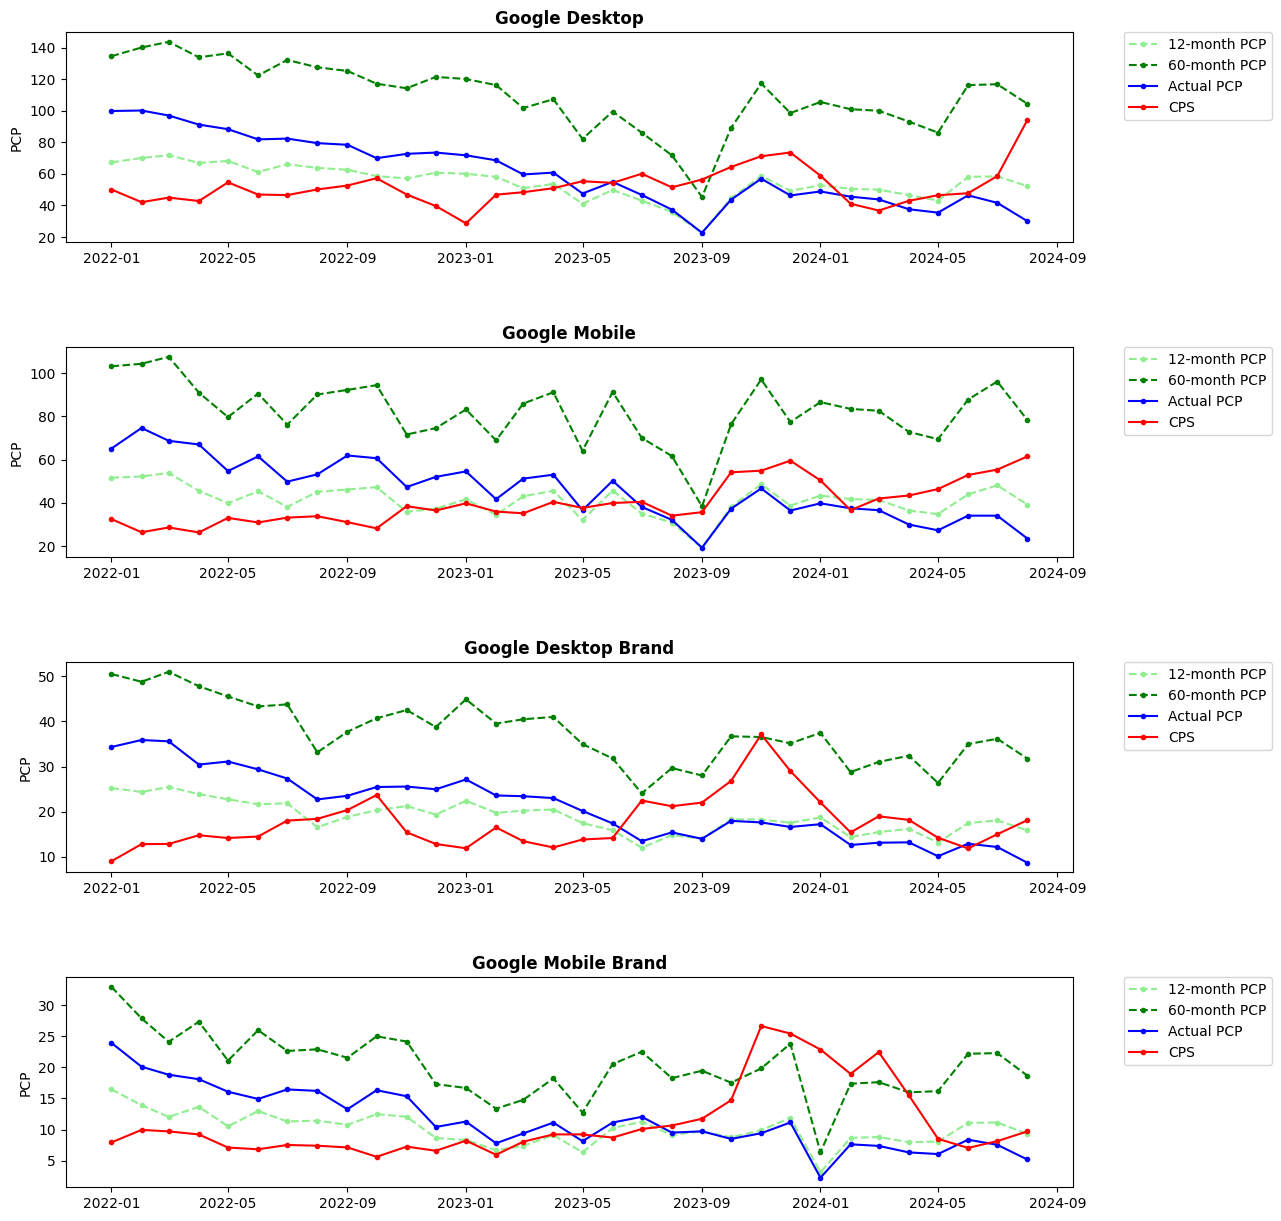

In [9]:
google_plot(summary_all)

### (4) 2024 H1 Report

In [38]:
# 2024 H1 
summary_all_H1 = summary_all.loc[(summary_all.signup_month >= '2024-01-01') & (summary_all.signup_month < '2024-07-01')].reset_index(drop=True)
h1_report = summary_all_H1.groupby(['channels'], as_index=False)[['realized_pcp_per_signup', '12_mo_pcp_per_signup', '60_mo_pcp_per_signup', 'cps']].sum()

In [39]:
h1_report

,channels,realized_pcp_per_signup,12_mo_pcp_per_signup,60_mo_pcp_per_signup,cps
0,Google_Desktop,257.655855,301.126811,602.253623,273.908673
1,Google_Desktop_Brand,79.298545,95.467544,190.935088,100.761870
2,Google_Mobile,204.929368,241.370132,482.740264,271.470984
3,Google_Mobile_Brand,38.105362,47.824114,95.648228,95.301516
